# CutMix data augmentation for image classification (画像分類のためのCutMixによるデータ補強)

**Author:** [Sayan Nath](https://twitter.com/sayannath2350)<br>
**Date created:** 2021/06/08<br>
**Last modified:** 2021/06/08<br>
**Description:** Data augmentation with CutMix for image classification on CIFAR-10.

## 序章

_CutMix_は、地域別ドロップアウト戦略に見られる情報損失と非効率性の問題を解決するデータ補強技術です。
ピクセルを削除して黒やグレーのピクセルやガウスノイズで埋めるのではなく、削除した領域を別の画像のパッチで置き換えます。
その際，結合された画像のピクセル数に比例して，グランドトゥルースラベルが混合されます．
CutMixは次のように提案されています．
[CutMix:Regularization Strategy to Train Strong Classifiers with Localizable Features](https://arxiv.org/pdf/1905.04899.pdf)
(Yun et al., 2019)

以下のような数式で実装されています。
![](https://i.imgur.com/cGvd13V.png)
ここで、`M`はランダムに描かれた2枚の画像から切り出し領域と塗り潰し領域を示す2値マスク、`λ`（`[0，1]`）はBeta（α，α）分布から引かれたものである。
[Beta(α, α) distribution](https://en.wikipedia.org/wiki/Beta_distribution)

バウンディングボックスの座標は：
![](https://i.imgur.com/eNisep4.png)
は、画像の場合、切り出し領域と塗り潰し領域を示す。
バウンディングボックスサンプリングは、以下のように表される。

![](https://i.imgur.com/Snph9aj.png)
ここで、`rx, ry` は上界を持つ一様分布からランダムに引き出される。

## 設定

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

## CIFAR-10データセットの読み込み

この例では
[CIFAR-10 image classification dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

class_names = [
    "Airplane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck",
]

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


## ハイパーパラメータの定義

In [4]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 32

## 画像前処理関数の定義

In [5]:
def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
    return image, label

## データをTensorFlowの`Dataset`オブジェクトに変換します。

In [6]:
train_ds_one = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
)

train_ds_two = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
)

train_ds_simple = tf.data.Dataset.from_tensor_slices((x_train, y_train))

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_ds_simple = (
    train_ds_simple.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# 同じトレーニングデータからシャッフルされた2つのデータセットを結合します。
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

test_ds = (
    test_ds.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

2021-12-23 22:21:11.361172: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-23 22:21:11.361440: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



## CutMixデータ補強関数の定義

CutMix関数は，2つの `image` と `label` のペアを受け取り、拡張を行います。この関数は[ベータ分布](https://en.wikipedia.org/wiki/Beta_distribution)から `λ(l)` をサンプリングし`get_box` 関数からバウンディングボックスを返します。そして、2枚目の画像（`image2`）をクロップし、この画像を最終的なパディング画像の同じ位置に配置します。

In [7]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


@tf.function
def get_box(lambda_value):
    cut_rat = tf.math.sqrt(1.0 - lambda_value)

    cut_w = IMG_SIZE * cut_rat  # rw
    cut_w = tf.cast(cut_w, tf.int32)

    cut_h = IMG_SIZE * cut_rat  # rh
    cut_h = tf.cast(cut_h, tf.int32)

    cut_x = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # rx
    cut_y = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # ry

    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)

    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1

    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1

    return boundaryx1, boundaryy1, target_h, target_w


@tf.function
def cutmix(train_ds_one, train_ds_two):
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two

    alpha = [0.25]
    beta = [0.25]

    # ベータ分布からサンプルを得る
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # ラムダの定義
    lambda_value = lambda_value[0][0]

    # バウンディングボックスのオフセット、高さ、幅の取得
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    # 2枚目の画像（`image2`）からパッチを取得します。
    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # 同じオフセットで `image2` パッチ (`crop2`) をパッド化する。
    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )
    # 1枚目の画像（`image1`）からパッチを取得します。
    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    # 同じオフセットで `image1` パッチ (`crop1`) をパッド化する。
    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )

    # image1` からパッチを引いて、1枚目の画像を修正します。
    # (`image2` のパッチを適用する前に)
    image1 = image1 - img1
    # 修正した `image1` と `image2` を足して、CutMix 画像を作成します。
    image = image1 + image2

    # 画素数に応じたLambdaの調整
    lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
    lambda_value = tf.cast(lambda_value, tf.float32)

    # 両画像のラベルを組み合わせる
    label = lambda_value * label1 + (1 - lambda_value) * label2
    return image, label

**注**: 2つの画像を組み合わせて1つの画像にしています。

## CutMixを適用した後の新しいデータセットを可視化する

2021-12-23 22:24:45.984795: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-23 22:24:45.985327: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


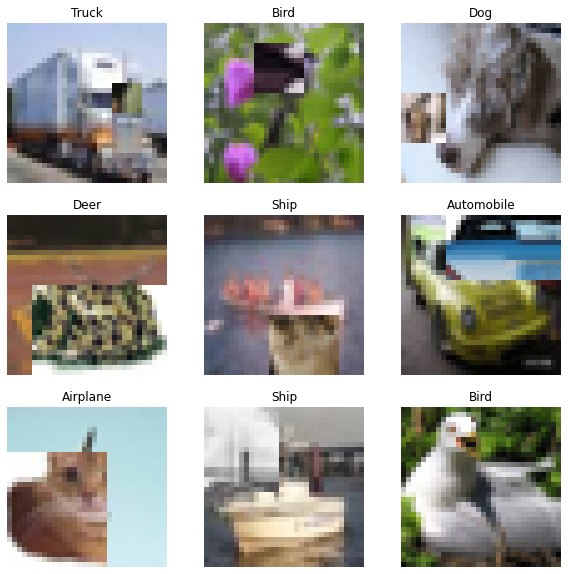

In [8]:
# 新しいデータセットを作成するには、`cutmix`ユーティリティーを使用します。
train_ds_cmu = (
    train_ds.shuffle(1024)
    .map(cutmix, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# データセットから9つのサンプルをプレビューしてみましょう。
image_batch, label_batch = next(iter(train_ds_cmu))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis("off")

## ResNet-20モデルの定義

In [9]:
def resnet_layer(
    inputs,
    num_filters=16,
    kernel_size=3,
    strides=1,
    activation="relu",
    batch_normalization=True,
    conv_first=True,
):
    conv = keras.layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        strides=strides,
        padding="same",
        kernel_initializer="he_normal",
        kernel_regularizer=keras.regularizers.l2(1e-4),
    )
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = keras.layers.BatchNormalization()(x)
        if activation is not None:
            x = keras.layers.Activation(activation)(x)
    else:
        if batch_normalization:
            x = keras.layers.BatchNormalization()(x)
        if activation is not None:
            x = keras.layers.Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v20(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError("depth should be 6n+2 (eg 20, 32, 44 in [a])")
    # モデル定義を開始します。
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = keras.layers.Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # 残留ユニットのスタックをインスタンス化
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # ファーストレイヤーでありながらファーストスタックではない
                strides = 2  # ダウンサンプル
            y = resnet_layer(inputs=x, num_filters=num_filters, strides=strides)
            y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
            if stack > 0 and res_block == 0:  # ファーストレイヤーでありながらファーストスタックではない
                # 線形投影 残存するショートカットの接続に一致
                # change dims
                x = resnet_layer(
                    inputs=x,
                    num_filters=num_filters,
                    kernel_size=1,
                    strides=strides,
                    activation=None,
                    batch_normalization=False,
                )
            x = keras.layers.add([x, y])
            x = keras.layers.Activation("relu")(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = keras.layers.AveragePooling2D(pool_size=8)(x)
    y = keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(
        num_classes, activation="softmax", kernel_initializer="he_normal"
    )(y)

    # Instantiate model.
    model = keras.models.Model(inputs=inputs, outputs=outputs)
    return model


def training_model():
    return resnet_v20((32, 32, 3), 20)


initial_model = training_model()
initial_model.save_weights("initial_weights.h5")

## CutMixで拡張されたデータセットでモデルを学習

In [10]:
model = training_model()
model.load_weights("initial_weights.h5")

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_ds_cmu, validation_data=test_ds, epochs=15)

test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

Epoch 1/15


2021-12-23 22:26:21.676161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - ETA: 0s - loss: 1.9244 - accuracy: 0.4053

2021-12-23 22:27:38.330083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 83s 48ms/step - loss: 1.9244 - accuracy: 0.4053 - val_loss: 1.4003 - val_accuracy: 0.5584
Epoch 2/15
1563/1563 [==============================] - 72s 46ms/step - loss: 1.6613 - accuracy: 0.5343 - val_loss: 1.9148 - val_accuracy: 0.3926
Epoch 3/15
1563/1563 [==============================] - 68s 43ms/step - loss: 1.5531 - accuracy: 0.5830 - val_loss: 1.1062 - val_accuracy: 0.6721
Epoch 4/15
1563/1563 [==============================] - 66s 42ms/step - loss: 1.4899 - accuracy: 0.6142 - val_loss: 1.0326 - val_accuracy: 0.7035
Epoch 5/15
1563/1563 [==============================] - 72s 46ms/step - loss: 1.4427 - accuracy: 0.6349 - val_loss: 0.9193 - val_accuracy: 0.7354
Epoch 6/15
1563/1563 [==============================] - 74s 47ms/step - loss: 1.4070 - accuracy: 0.6515 - val_loss: 0.9799 - val_accuracy: 0.7170
Epoch 7/15
1563/1563 [==============================] - 67s 43ms/step - loss: 1.3832 - accuracy: 0.6648 - val_loss: 0.9575 - val_accura

## オーグメンテーションされていないオリジナルのデータセットを使ってモデルをトレーニングする

In [11]:
model = training_model()
model.load_weights("initial_weights.h5")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_ds_simple, validation_data=test_ds, epochs=15)

test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

Epoch 1/15


2021-12-23 22:44:01.264907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - ETA: 0s - loss: 1.4732 - accuracy: 0.5209

2021-12-23 22:44:50.673645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 54s 34ms/step - loss: 1.4732 - accuracy: 0.5209 - val_loss: 1.2967 - val_accuracy: 0.5981
Epoch 2/15
1563/1563 [==============================] - 57s 36ms/step - loss: 1.0628 - accuracy: 0.6791 - val_loss: 1.1977 - val_accuracy: 0.6501
Epoch 3/15
1563/1563 [==============================] - 57s 37ms/step - loss: 0.8947 - accuracy: 0.7450 - val_loss: 0.9829 - val_accuracy: 0.7163
Epoch 4/15
1563/1563 [==============================] - 56s 36ms/step - loss: 0.7903 - accuracy: 0.7822 - val_loss: 1.2201 - val_accuracy: 0.6762
Epoch 5/15
1563/1563 [==============================] - 57s 37ms/step - loss: 0.7145 - accuracy: 0.8132 - val_loss: 1.1846 - val_accuracy: 0.6917
Epoch 6/15
1563/1563 [==============================] - 54s 34ms/step - loss: 0.6560 - accuracy: 0.8390 - val_loss: 1.2705 - val_accuracy: 0.6942
Epoch 7/15
1563/1563 [==============================] - 54s 34ms/step - loss: 0.6082 - accuracy: 0.8596 - val_loss: 1.7398 - val_accura

## 備考

この例では，モデルを15エポック分学習させた．
我々の実験では，CIFAR-10 データセットにおいて，CutMix を使用したモデルは，拡張機能を使用しないモデル（72.70%）と比較して，より良い精度を達成しました．
(実験では80.36%)に対し、CutMixを使用していないモデル(72.70%)はより良い精度を達成しています。
また、CutMix 拡張機能を使用したモデルの方が、学習時間が短くて済むことがわかります。

CutMixのテクニックをさらに試すには、次のような方法があります。
[original paper](https://arxiv.org/abs/1905.04899).